In [1]:
# ANALISI SHAP DATASET DI TEST TOTALE, VISUALIZZAZIONE DIVISA PER IMPATTO SU CLASSE 0 E 1


In [22]:
import torch
from transformers import AutoTokenizer

import shap
import nltk
import pickle
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nltk.download("punkt")
from nltk.tokenize import sent_tokenize, word_tokenize

# from error_analysis_TRC import load_local_model
from TRC.utils import create_token_dict, get_top_n, load_local_TRC_model


from better_profanity import profanity
from copy import deepcopy
from ast import literal_eval

[nltk_data] Downloading package punkt to /home/agensale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'roberta-large'

model_path = '/home/agensale/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/agensale/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/saved-model/config.json'

In [39]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_TRC_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
# come input prende una lista di tweet
def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [41]:
explainer = shap.Explainer(f, masker = tokenizer)
explainer

In [25]:
news_corrette = pd.read_csv('/home/agensale/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/news_corrette.csv', index_col = 0, converters={'News tok':literal_eval})
news_errate = pd.read_csv('/home/agensale/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/news_errate.csv', index_col = 0, converters={'News tok':literal_eval})
news_total = pd.concat([news_corrette, news_errate])

In [27]:
news_total.head()

,News,News tok,True label,Pred label
0,Lithuanian authorities have seized more than t...,"[[Lithuanian, authorities, have, seized, more,...",1,1
1,Global financial markets are stronger and more...,"[[Global, financial, markets, are, stronger, a...",0,0
2,LONDON Reuters The dollar kept close to the pr...,"[[LONDON, Reuters, The, dollar, kept, close, t...",0,0
3,COLLEAGUES of aid worker Margaret Hassan kidna...,"[[COLLEAGUES, aid, worker, Margaret, Hassan, k...",0,0
4,Malcolm Glazer edged closer to triggering a ma...,"[[Malcolm, Glazer, edged, closer, triggering, ...",0,0


In [28]:
# Espandi le liste di liste in nuove righe
news_total = news_total.explode("News tok")

# Resetta l'indice del DataFrame risultante
news_total.reset_index(drop=True, inplace=True)




In [17]:
news_total = news_total.sample(n=1500, random_state=42, ignore_index= True)

In [18]:
len(news_total)

1500

In [16]:
def flatten_lists(row):
    # Utilizziamo una list comprehension per appiattire le liste di liste mantenendo le stringhe intatte
    return [item for sublist in row for item in sublist]

# Applica la funzione a ogni riga del DataFrame
news_total['lista_piatta'] = news_total['News tok'].apply(flatten_lists)

In [17]:
def clean_strings(big_tokens_list):
    tags = ['@USER','USER', 'HTTPURL', 'HTTP', 'URL']
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    clean_list = []
    for t_list in big_tokens_list:
        tokens = deepcopy(t_list)
        for token, i in zip(t_list, range(len(t_list))):
            tmp = deepcopy(token)
            tmp = tmp.strip()
            tmp = tmp.lower()
            if tmp in string.punctuation or \
            tmp.upper() in tags or \
            tmp == '...' or  tmp == '....' or \
            tmp in stop_words or \
            profanity.contains_profanity(tmp) or \
            len(tmp) < 3:
                tokens.remove(token)
        clean_list.append(' '.join(tokens))
    return clean_list
        

In [14]:
# SHAP FOR ALL DS

In [30]:
# all_tweets = df_total['Tweet'].tolist()
# all_tweets_tokens = news_total['lista_piatta'].tolist()
all_tweets_tokens = news_total['News tok'].tolist()

In [31]:
all_tweets_tokens

[['Lithuanian',
  'authorities',
  'have',
  'seized',
  'more',
  'than',
  'tons',
  'imported',
  'poultry',
  'meat',
  'due',
  'potential',
  'Salmonella',
  'contamination',
  'the',
  'space',
  'three',
  'months.From',
  'June',
  'August',
  'this',
  'year',
  'the',
  'State',
  'Food',
  'and',
  'Veterinary',
  'Service',
  'VMVT',
  'banned',
  'the',
  'placing',
  'the',
  'market',
  'batches',
  'poultry',
  'meat',
  'imported',
  'Lithuania',
  'from',
  'Poland',
  'Hungary',
  'and',
  'Romania.More',
  'than',
  'half',
  'the',
  'non',
  'compliant',
  'meat',
  'tons',
  'seven',
  'batches',
  'was',
  'imported',
  'from',
  'Poland.'],
 ['total',
  'tons',
  'two',
  'lots',
  'originated',
  'Hungary',
  'and',
  'three',
  'tons',
  'one',
  'lot',
  'came',
  'from',
  'Romania.Year',
  'farAll',
  'poultry',
  'products',
  'that',
  'reached',
  'Lithuania',
  'and',
  'contained',
  'Salmonella',
  'have',
  'been',
  'withdrawn',
  'from',
  'the',

In [32]:
cleaned_all = clean_strings(all_tweets_tokens)
cleaned_all[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/agensale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Lithuanian authorities seized tons imported poultry meat due potential Salmonella contamination space three months.From June August year State Food Veterinary Service VMVT banned placing market batches poultry meat imported Lithuania Poland Hungary Romania.More half non compliant meat tons seven batches imported Poland.',
 'total tons two lots originated Hungary three tons one lot came Romania.Year farAll poultry products reached Lithuania contained Salmonella withdrawn market destroyed.',
 'detained warehouses enter market.',
 'companies involved received sanctions VMVT inspectors putting unsafe poultry market.Lithuanian authorities stopped supply tons poultry meat first five months',
 'batches possibly unsafe poultry analyzed first quarter year originated Poland.Three public warnings made recently Polish authorities Salmonella poultry products eggs.']

In [35]:
lunghezza_media = sum(len(s) for s in cleaned_all) / len(cleaned_all)

# Stampa il risultato
print("Lunghezza media:", lunghezza_media)

Lunghezza media: 156.71835803876854


In [42]:
# CREAZIONE SHAP_VALUES E SALVATAGGIO IN PICKLE


save_path = '/home/agensale/rora_tesi_new/log/log_EFRA/news/roberta-large/from_finetuned/10_epoch/SampleAgroknow/True_weight/42_seed/shap/'
shap_values = explainer(cleaned_all)
print(shap_values.shape)
print(shap_values.output_names)
with open(save_path + 'shap_values_all_test.pickle', 'wb') as handle:
    pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   0%|          | 1/16663 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   0%|          | 3/16663 [04:17<595:08:03, 128.60s/it]


KeyboardInterrupt: 

In [4]:
# LETTURA DA FILE PICKLE SHAP_VALUES SALVATI 

save_path = '/home/agensale/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/'
with open(save_path + 'shap_values_all_test.pickle', 'rb') as handle:
    shap_values_loaded = pickle.load(handle)

In [6]:
def token_dict(shap_values):
    token_dict_pos = {}
    token_dict_neg = {}
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    val = [shap_values[i] for i in range(len(shap_values))]
    for el in val:
        for i in range(len(el)-1):
            token = el[i].data
            token = token.strip()
            if token not in string.punctuation and token != 'USER' and token != 'HTTPURL' and token != 'HTTP' and token!='URL' and token != '...' and len(token) >= 3:
                shap_val = el[i].values
                # pos = abs(shap_val[0])
                # neg = abs(shap_val[1])
                pos = shap_val[1]
                neg = shap_val[0]
                token = token.lower()
                if token not in stop_words:
                    if not profanity.contains_profanity(token):
                        if (token not in token_dict_pos.keys()) or (token not in token_dict_neg.keys()):
                            token_dict_pos[token] = pos
                            token_dict_neg[token] = neg
                        else:
                            token_dict_pos[token] += pos
                            token_dict_neg[token] += neg
                            
    return token_dict_pos, token_dict_neg

In [7]:
token_dict_pos, token_dict_neg = token_dict(shap_values_loaded)

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
sorted_pos = sorted(token_dict_pos.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_pos = dict(sorted_pos)

sorted_neg = sorted(token_dict_neg.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_neg = dict(sorted_neg)

In [ ]:
# PLOT FOR CLASS 1

In [42]:
def remove_keywords(dict):
    chiavi_da_eliminare = ["foodpoisoning", "food", "poison", "poisoning", "stomachache", "stomach", "vomit", "puke", "diarrhea", "runs", "the", "omach"] 

    for chiave in chiavi_da_eliminare:
        if chiave in dict:
            del dict[chiave]
        else:
            print(f"La chiave '{chiave}' non esiste nel dizionario.")
    

In [43]:
to_del = []
for k in sorted_d_pos.keys():
    if len(k) <= 3:
        to_del.append(k)

In [44]:
for k in to_del:
    del sorted_d_pos[k]

In [45]:
remove_keywords(sorted_d_pos)

La chiave 'foodpoisoning' non esiste nel dizionario.
La chiave 'stomachache' non esiste nel dizionario.
La chiave 'vomit' non esiste nel dizionario.
La chiave 'puke' non esiste nel dizionario.
La chiave 'the' non esiste nel dizionario.


In [46]:
to_plot_pos = get_top_n(20,sorted_d_pos)

In [47]:
def colors(x):
    colorsValue = []
    for value in x.values():
        if value < 0:
            colorsValue.append('darkturquoise')
        elif value >= 0:
            colorsValue.append('orange')
    return colorsValue

In [48]:
colors_list = colors(to_plot_pos)

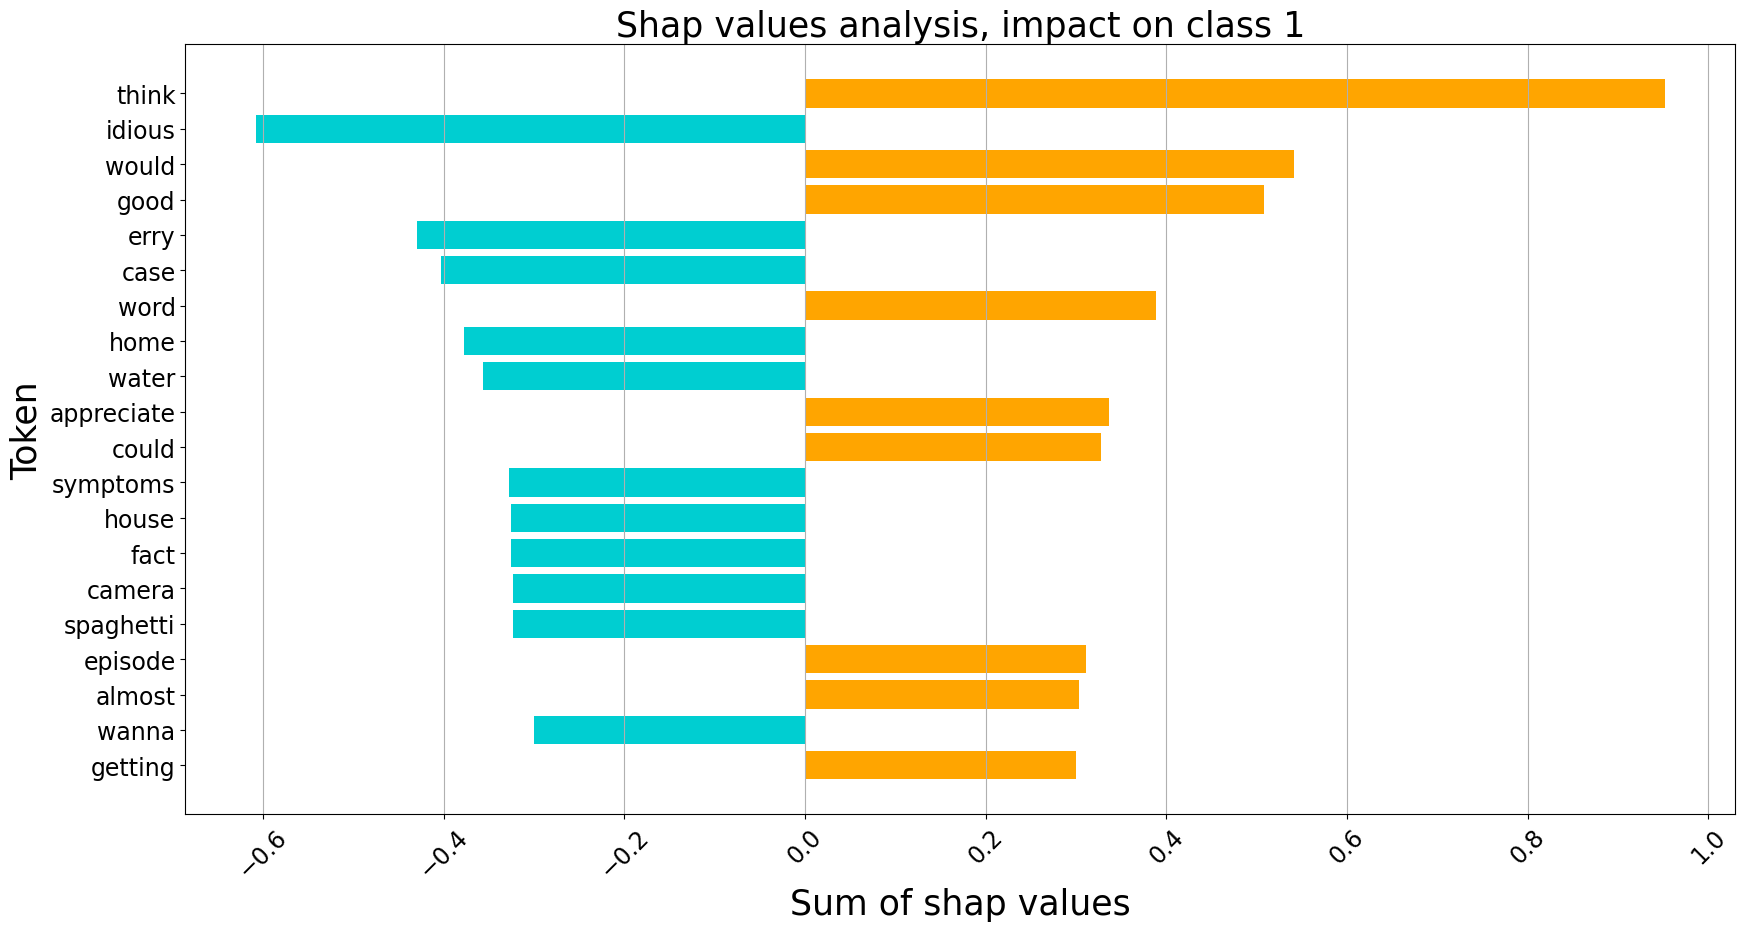

In [49]:
# IMPACT ON CLASS 1

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_pos)), list(to_plot_pos.values()), tick_label=list(to_plot_pos.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 1', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [2]:
# shap.plots.bar(shap_values_loaded[:,:,1].sum(0), order=shap.Explanation.argsort.flip)

In [21]:
# PLOT FOR CLASS 0

In [50]:
to_del = []
for k in sorted_d_neg.keys():
    if len(k) <= 3:
        to_del.append(k)

In [52]:
for k in to_del:
    del sorted_d_neg[k]

In [53]:
remove_keywords(sorted_d_neg)

La chiave 'foodpoisoning' non esiste nel dizionario.
La chiave 'stomachache' non esiste nel dizionario.
La chiave 'vomit' non esiste nel dizionario.
La chiave 'puke' non esiste nel dizionario.
La chiave 'the' non esiste nel dizionario.


In [54]:
to_plot_neg = get_top_n(20, sorted_d_neg)

In [55]:
colors_list = colors(to_plot_neg)

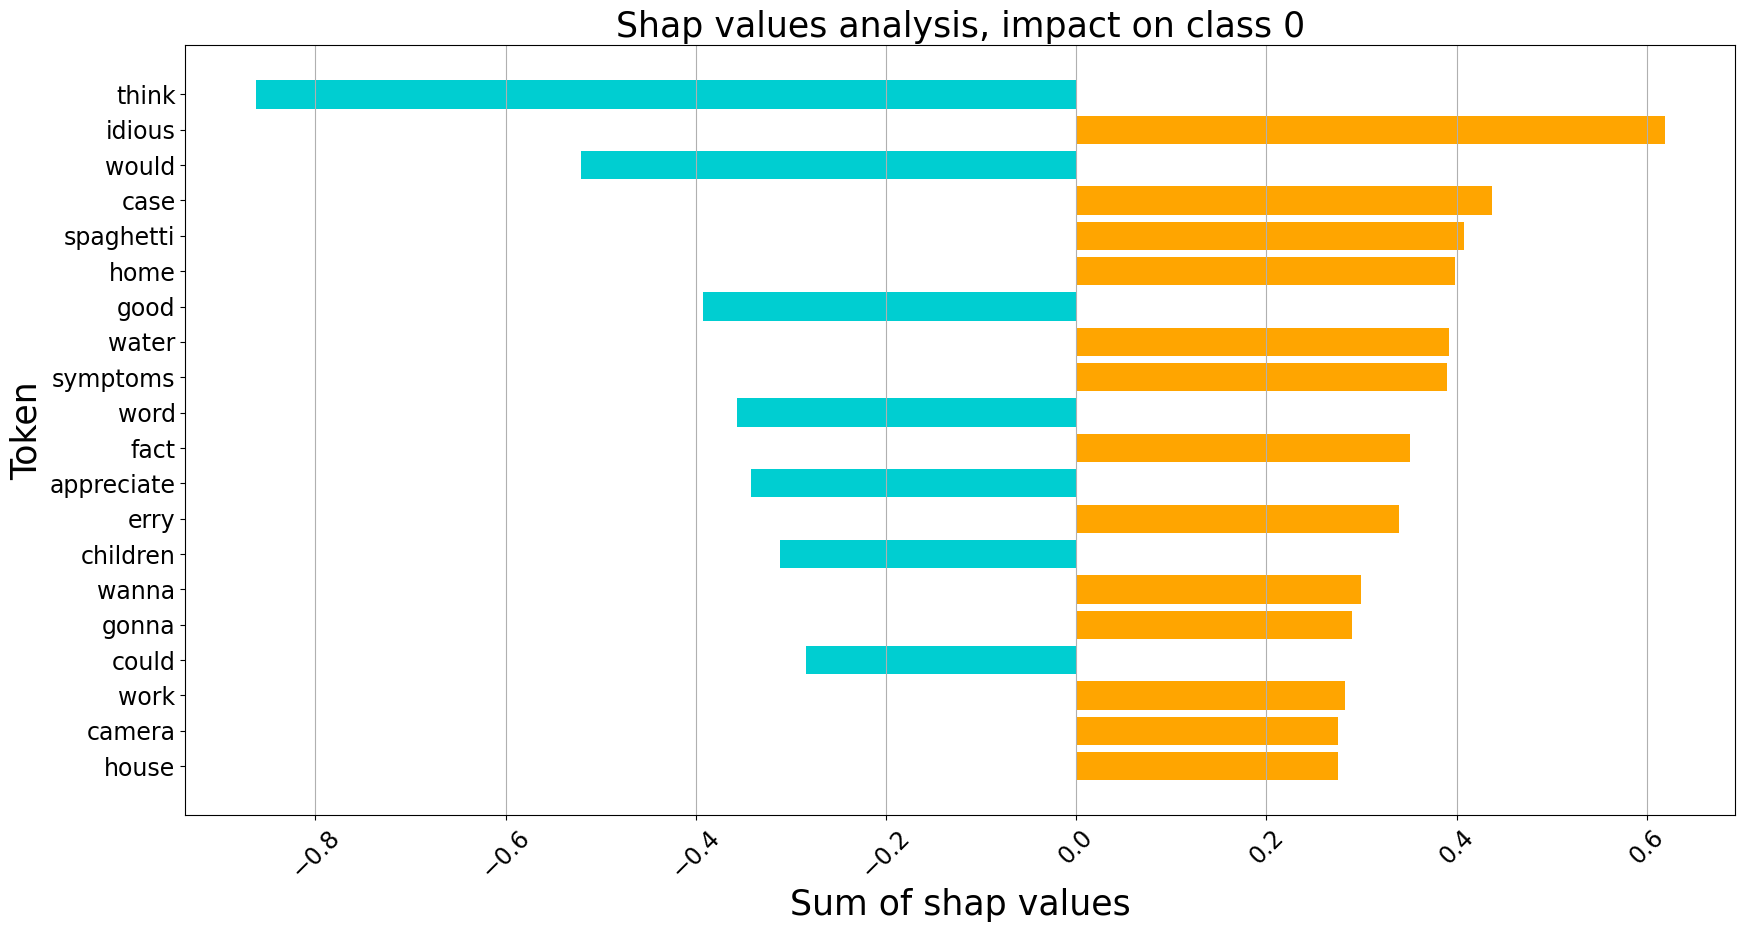

In [56]:
# IMPACT ON CLASS 0

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_neg)), list(to_plot_neg.values()), tick_label=list(to_plot_neg.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 0', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [1]:
# shap.plots.bar(shap_values_loaded[:,:,0].sum(0),  order=shap.Explanation.argsort.flip)